We solve the steady advection dominated skew to mesh benchmark problem as described in [links go here] using the various methods encountered in class. The problem entails solving the advection diffusion equation 
$$-\kappa \Delta u + \mathbf{a}\cdot \nabla u = 0, \quad\text{where }\kappa = 10^{-3},\text{ and } \mathbf{a} = \left(\cos\left(\frac{\pi}{4}\right), \sin\left(\frac{\pi}{4}\right)\right)$$

with dirichlet boundary conditions as shown below 


<img src="files/advectiondominatedskewmesh.jpg">


In [22]:
import nutils as ntl
import numpy as np
import matplotlib.pyplot as plt
import inspect
from matplotlib import collections

## Galerkin

**Weak Form**: $$0 = \int_\Omega \kappa \, N_{A, j}\cdot u_{, j} \,-\, u\, N_{A, k} \,a_k \, dx$$
where $N_i$ is a basis function.

optimize > solve > solving 120 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-17
optimize > constrained 120/961 dofs
optimize > optimum value 9.62e-03
solve > solving 841 dof system to machine precision using direct solver
solve > solver returned with residual 5e-17
ADSM_Gal.png


(0.0, 1.0000000000000004, 0.0, 1.0000000000000002)

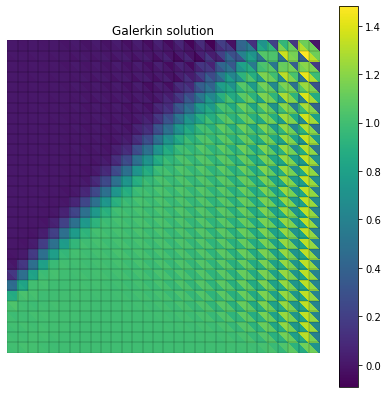

In [54]:
degree = 1 #degree of basis functions
nelems = 30 #number of elements along edge of unit square
etype = 'square'

theta = np.pi/4
topo, geom =  ntl.mesh.unitsquare(nelems, etype) #rectilinear([np.linspace(0,1, nx), np.linspace(0,1, ny) ])
ns = ntl.function.Namespace()
ns.x = geom
ns.a = np.array([np.cos(np.pi/4), np.sin(np.pi/4)])
ns.kappa = 1e-3
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'


#Dirichlet boundary condition
ns.badbnd = topo.boundary['left'].indicator(topo.boundary['left'][0:int(nelems/5)])

sqr = topo.boundary['bottom'].integral('(u - 1)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['left'].integral( '(u - badbnd)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u
'''
print(topo.boundary['left'][0:int(nelems/5)])    
bezier = topo.sample('bezier', 2)
bezier2 = topo.boundary['left'].sample('bezier', 2)
x = bezier2.eval(ns.x[1])
badbnd1 = bezier2.eval(2* topo.boundary['left'].indicator(topo.boundary['left'][0:int(nelems/5)]))
print(badbnd1, x)
plt.plot(x, badbnd1, '*')
''' 

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 

lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('ADSM_Gal.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('Galerkin solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

## SUPG

**Weak Form**:
$$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k}\,a_k \, dx + \int_\Omega \tau\, a_n N_{A, n} 
( - \kappa\, u_{, mm} + a_k\, u_{,k}) \, dx$$

We use $\tau = \frac{h}{2|a|}$ in the code below

optimize > solve > solving 120 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 1e-17
optimize > constrained 120/961 dofs
optimize > optimum value 9.62e-03
solve > solving 841 dof system to machine precision using direct solver
solve > solver returned with residual 1e-16


(0.0, 1.0000000000000004, 0.0, 1.0000000000000002)

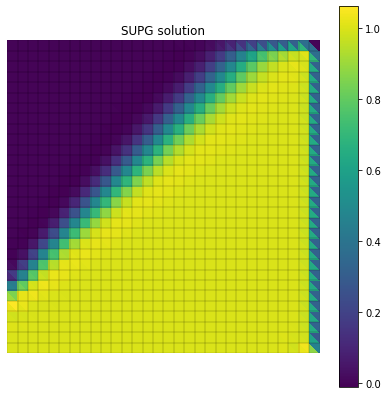

In [60]:
degree = 1 #degree of basis functions
nelems = 30 #number of elements along edge of unit square
etype = 'square'

theta = np.pi/4
topo, geom =  ntl.mesh.unitsquare(nelems, etype) #rectilinear([np.linspace(0,1, nx), np.linspace(0,1, ny) ])
ns = ntl.function.Namespace()
ns.x = geom
ns.a= np.array([np.cos(theta), np.sin(theta)])
ns.kappa = 1e-3
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'

#element intrinsic time scale
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.anorm = '(a_i a_i)^.5'
ns.tau = 'h / (2 anorm)'

#dirichlet boundary conditions
ns.badbnd = topo.boundary['left'].indicator(topo.boundary['left'][0:int(nelems/5)])
sqr = topo.boundary['bottom'].integral('(u - 1)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['left'].integral( '(u - badbnd)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
res += topo.integral( 'tau a_k basis_i,k (-kappa u_,jj + a_n u_,n)  d:x' @ ns, degree = degree * 2) 

lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('ADSM_SUPG.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize= (7, 7))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('SUPG solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')
#'''

## Galerkin/Least squares

**Weak Form**:
$$0 = \int_\Omega \kappa \, N_{A, j}\, u_{, j} \,-\, u\, N_{A, k}\,a_k \, dx + \int_\Omega \tau\, (-\kappa\,N_{A, rr}\,+\, a_n N_{A, n}) 
( - \kappa\, u_{, mm} + a_k\, u_{,k}) \, dx$$

We use $\tau = \frac{h}{2|a|}$ in the code below

optimize > solve > solving 240 dof system to machine precision using direct solver
optimize > solve > solver returned with residual 2e-17
optimize > constrained 240/3721 dofs
optimize > optimum value 3.93e-03
solve > solving 3481 dof system to machine precision using direct solver
solve > solver returned with residual 4e-16


(0.0, 1.0000000000000004, 0.0, 1.0000000000000002)

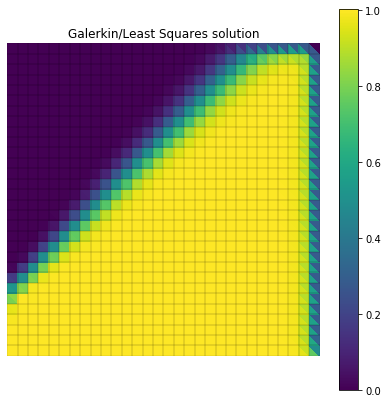

In [63]:
degree = 2 #degree of basis functions. degree = 1 gives SUPG
nelems = 30 #number of elements along edge of unit square
etype = 'square'

theta = np.pi/4
topo, geom =  ntl.mesh.unitsquare(nelems, etype) #rectilinear([np.linspace(0,1, nx), np.linspace(0,1, ny) ])
ns = ntl.function.Namespace()
ns.x = geom
ns.a= np.array([np.cos(theta), np.sin(theta)])
ns.kappa = 1e-3
ns.basis = topo.basis('lagrange', degree = degree)
ns.u = 'basis_i ?dofs_i'

#element intrinsic time scale
ns.h = np.sqrt(2/nelems**2) #mesh size parameter
ns.anorm = '(a_i a_i)^.5'
ns.tau = 'h / (2 anorm)'

#dirichlet boundary conditions
ns.badbnd = topo.boundary['left'].indicator(topo.boundary['left'][0:int(nelems/5)])
sqr = topo.boundary['bottom'].integral('(u - 1)^2 d:x' @ ns, degree = degree*2)
sqr += topo.boundary['left'].integral( '(u - badbnd)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['right'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
sqr += topo.boundary['top'].integral( '(u - 0)^2 d:x' @ ns, degree = degree*2 )
cons = ntl.solver.optimize('dofs', sqr, droptol=1e-15) #this applies the boundary condition to u

#residual
res = topo.integral( '(kappa basis_i,j u_,j  - u basis_i,n a_n) d:x' @ ns, degree = degree * 2) 
res += topo.integral('tau (-kappa basis_i,mm + a_k basis_i,k) (-kappa u_,jj + a_n u_,n)  d:x' @ ns, degree= degree*2) 

lhs = ntl.solver.solve_linear('dofs', res, constrain= cons)

bezier = topo.sample('bezier', 2)
x = bezier.eval('x_i' @ ns)
u = bezier.eval('u' @ ns, dofs = lhs)

#ntl.export.triplot('ADSM_GLS.png', x, u, tri=bezier.tri, hull=bezier.hull)
fig = plt.figure(figsize= (7,7))
ax = fig.add_subplot(111, aspect= 'equal')
im = ax.tripcolor(x[:,0], x[:, 1], bezier.tri, u)
fig.colorbar(im)
ax.autoscale(enable= True, axis = 'both', tight = 'True')
ax.set_title('Galerkin/Least Squares solution')
ax.add_collection(collections.LineCollection(x[bezier.hull], colors='k', linewidths= .1))
plt.axis('off')

In [40]:
#print((beta *beta).sum(0)) #ct.getfullargspec(topo.basis))
#elp(np.dot)#(topo.basis)
help(ntl.export.triplot)
#print(topo.boundary)
#help(bezier.eval)
a = [1 ,2, 3, 4, 5, 8, 6, 7]
print(a[:])
print(np.cos(np.pi))

Help on function triplot in module nutils.export:

triplot(name, points, values=None, *, tri=None, hull=None, cmap=None, clim=None, linewidth=0.1, linecolor='k')

[1, 2, 3, 4, 5, 8, 6, 7]
-1.0


In [36]:
help(ax.add_collection)

Help on method add_collection in module matplotlib.axes._base:

add_collection(collection, autolim=True) method of matplotlib.axes._subplots.AxesSubplot instance
    Add a `~.Collection` to the axes' collections; return the collection.

